.. index:: Equations; Euler equations

# Euler System of Gas Dynamics

In [1]:
try:
    import dune.femdg
except ImportError:
    print("This example needs 'dune.femdg' - skipping")
    import sys
    sys.exit(0)

import numpy
from matplotlib import pyplot
from ufl import *
from dune.grid import structuredGrid, reader
import dune.fem
import dune.ufl
from dune.fem.space import dgonb, finiteVolume
from dune.fem.function import gridFunction
from dune.femdg import femDGOperator
from dune.femdg.rk import femdgStepper
from dune.fem.utility import lineSample
from dune.femdg import BndValue, BndFlux_v, BndFlux_c

dune.fem.threading.use = 4

.. index:: Methods; Stabilized Discontinuous Galerkin

The dune-fem-dg module can either used stabilizer DG methods to solve
this type of problem or higher order FV methods based on linear
reconstruction. The following function uses a finite-volume space when
order=0 and a dg space with orthonormal polynomials otherwise.
Note that when a limiter is then used in the scheme, the finite-volume
scheme will use linear reconstruction:

In [2]:
def getSpace( gv, order ):
    return finiteVolume( gridView, dimRange=4 ) if order==0 else\
           dgonb( gridView, dimRange=4, order=order )

Basic model for hyperbolic conservation law

In [3]:
class Model:
    gamma = 1.4
    # helper function
    def toPrim(U):
        v = as_vector( [U[i]/U[0] for i in range(1,3)] )
        kin = dot(v,v) * U[0] / 2
        pressure = (Model.gamma-1)*(U[3]-kin)
        return U[0], v, pressure

    # interface methods for model
    @classmethod
    def F_c(cls,t,x,U):
        rho, v, p = Model.toPrim(U)
        return as_matrix( [
                  [rho*v[0], rho*v[1]],
                  [rho*v[0]*v[0] + p, rho*v[0]*v[1]],
                  [rho*v[0]*v[1], rho*v[1]*v[1] + p],
                  [(U[3]+p)*v[0], (U[3]+p)*v[1]] ] )

    # simple 'outflow' boundary conditions on all boundaries
    boundary = {range(1,5): BndValue(lambda t,x,U: U)}

    # interface method needed for LLF and time step control
    @classmethod
    def maxWaveSpeed(cls,t,x,U,n):
        rho, v, p = Model.toPrim(U)
        return abs(dot(v,n)) + sqrt(Model.gamma*p/rho)

.. index:: Methods; Limiter

Add methods for limiting

In [4]:
def velocity(cls,t,x,U):
    _, v ,_ = Model.toPrim(U)
    return v
def physical(cls,t,x,U):
    rho, _, p = Model.toPrim(U)
    return conditional( rho>1e-8, conditional( p>1e-8 , 1, 0 ), 0 )
def jump(cls,t,x,U,V):
    _,_, pL = Model.toPrim(U)
    _,_, pR = Model.toPrim(V)
    return (pL - pR)/(0.5*(pL + pR))
Model.velocity = classmethod(velocity)
Model.physical = classmethod(physical)
Model.jump     = classmethod(jump)

Method to evolve the solution in time

In [5]:
def evolve(space, u_h, limiter="MinMod"):
    lu_h = u_h.localFunction()
    @gridFunction(space.gridView,name="rho",order=space.order)
    def rho(e,x):
        lu_h.bind(e)
        return lu_h(x)[0]
    operator = femDGOperator(Model, space, limiter=limiter) # note: that u_h.space fails since not ufl_space
    stepper  = femdgStepper(order=space.order+1 if space.order>0 else 2, operator=operator)
    operator.applyLimiter(u_h)

    t = 0
    saveStep = 0.1
    fig = pyplot.figure(figsize=(30,10))
    rho.plot(gridLines="white", figure=(fig, 131), colorbar=False, clim=[0.125,1])
    c = 1
    while t <= 0.3:
        operator.setTime(t)
        t += stepper(u_h)
        if t > saveStep:
            print(t)
            saveStep += 0.1
            rho.plot(gridLines="white", figure=(fig, 131+c), colorbar=False, clim=[0.125,1])
            c += 1

    res = numpy.zeros((2,space.gridView.size(0)))
    for i,e in enumerate(space.gridView.elements):
        x = e.geometry.center
        res[0][i] = x.two_norm
        res[1][i] = rho(e,e.geometry.toLocal(x))
    return res

A radial Riemann problem using [a triangle grid](triangle.dgf)

In [6]:
x = SpatialCoordinate(dune.ufl.domain(2))
initial = conditional(dot(x,x)<0.1,as_vector([1,0,0,2.5]),
                                   as_vector([0.125,0,0,0.25]))

domain = (reader.dgf, "triangle.dgf")

We start with a triangular grid

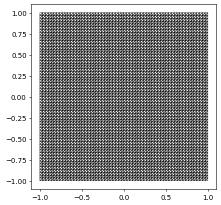

In [7]:
from dune.alugrid import aluSimplexGrid as simplexGrid
gridView = simplexGrid( domain, dimgrid=2 )
gridView.plot()

# fix the order to use and storage structure for results
res = {}
order = 1
space = getSpace( gridView, order )

Initial conditions for a radial Riemann problem

First solved on a triangle grid and minmod limiter

0.10067226533061213


0.20011688589049687


0.3006285980734703


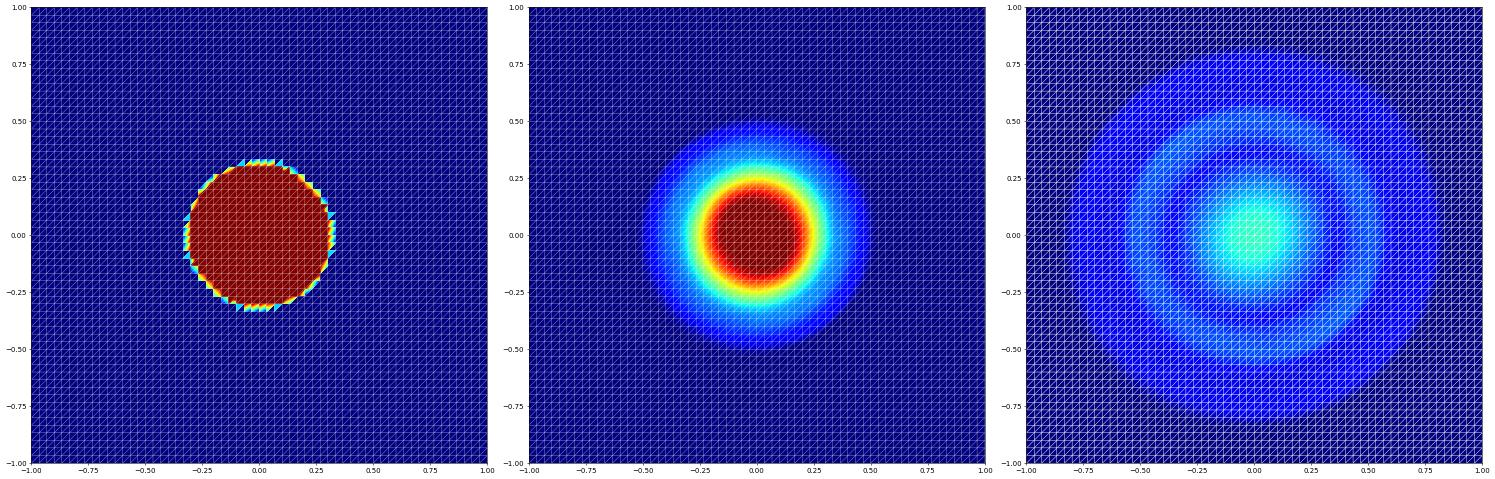

In [8]:
u_h   = space.interpolate( initial, name="solution")
res["simplex (minmod)"] = evolve(space,u_h)

Now a triangle grid without limiter (which of course fails)

8.089619106880421e+307
SOLUTION NOT VALID


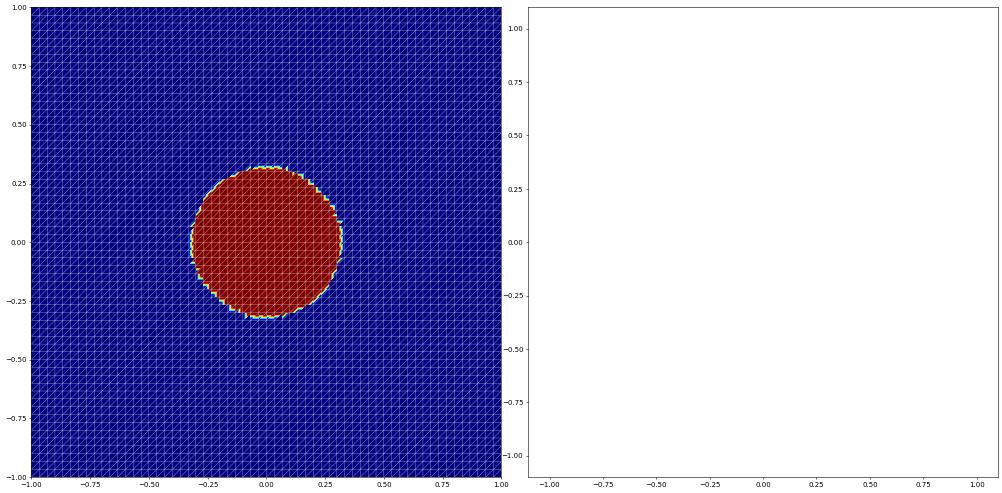

In [9]:
try:
    u_h   = space.interpolate( initial, name="solution")
    evolve(space,u_h,limiter=None)
except ValueError:
    print("SOLUTION NOT VALID")

Now a finite volume method first without reconstruction on the triangle grid

0.10210605133997673


0.20082317461244167


0.30230727763246446


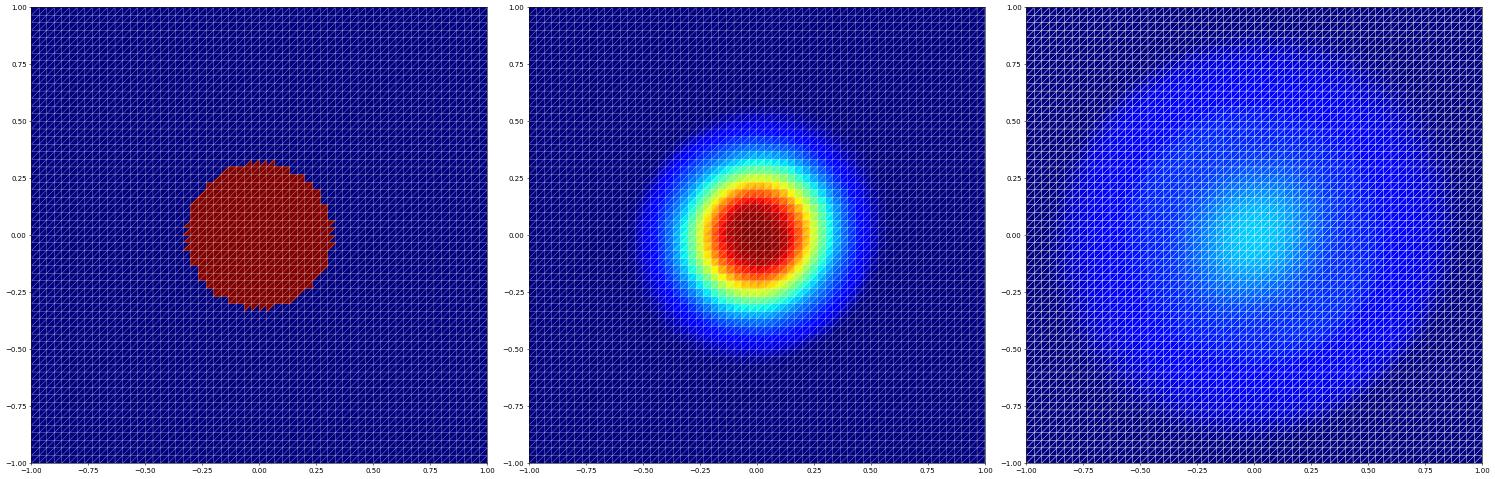

In [10]:
fvspace = getSpace( gridView, 0 )
u_h   = fvspace.interpolate( initial, name="solution")
res["simplex (fv)"] = evolve(fvspace,u_h,limiter=None)

and a finite volume method with reconstruction

0.10084269412206702


0.2018989967725324


0.3019024714106266


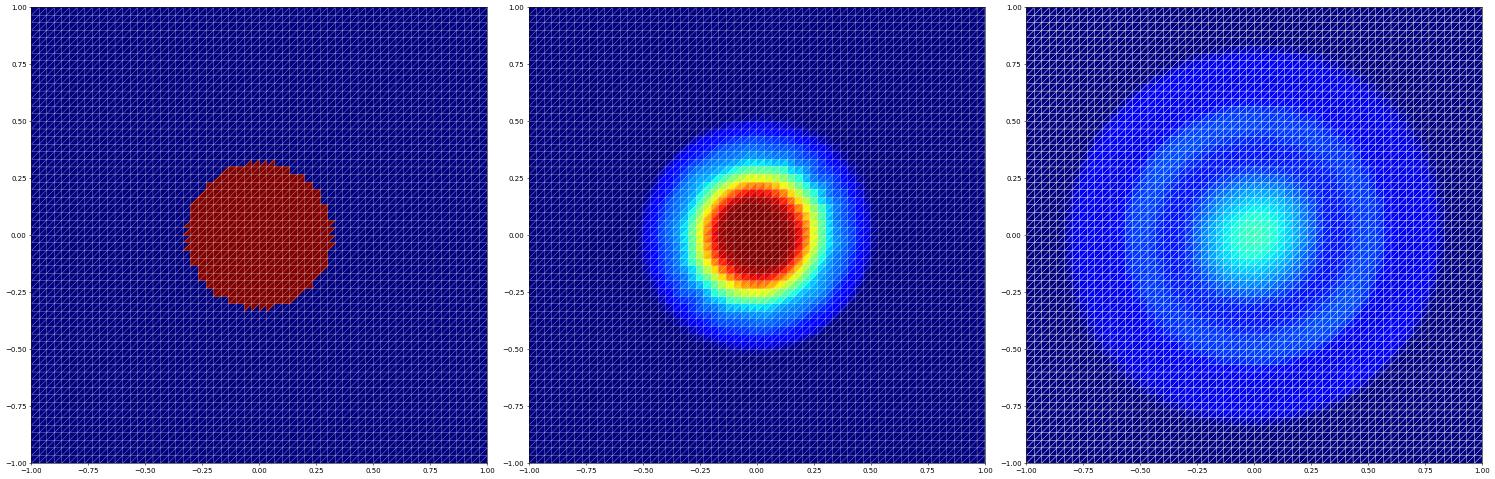

In [11]:
fvspace = getSpace( gridView, 0 )
u_h   = fvspace.interpolate( initial, name="solution")
res["simplex (higher order fv)"] = evolve(fvspace,u_h,limiter="MinMod")

Using a polygonal grid (dual grid of previous grid)

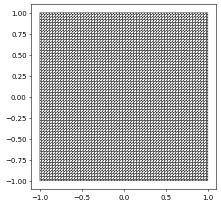

In [12]:
try:
    from dune.polygongrid import polygonGrid
    gridView = polygonGrid( domain, dualGrid=True )
except ImportError:
    print("dune.polygongrid module not found using the simplex grid again")
    gridView = simplexGrid( domain, dimgrid=2 )
gridView.plot()
space = getSpace( gridView, order )

Solution with limiter - fails as above without

0.10079052613578879


0.20000620030070312


0.30079672643648403


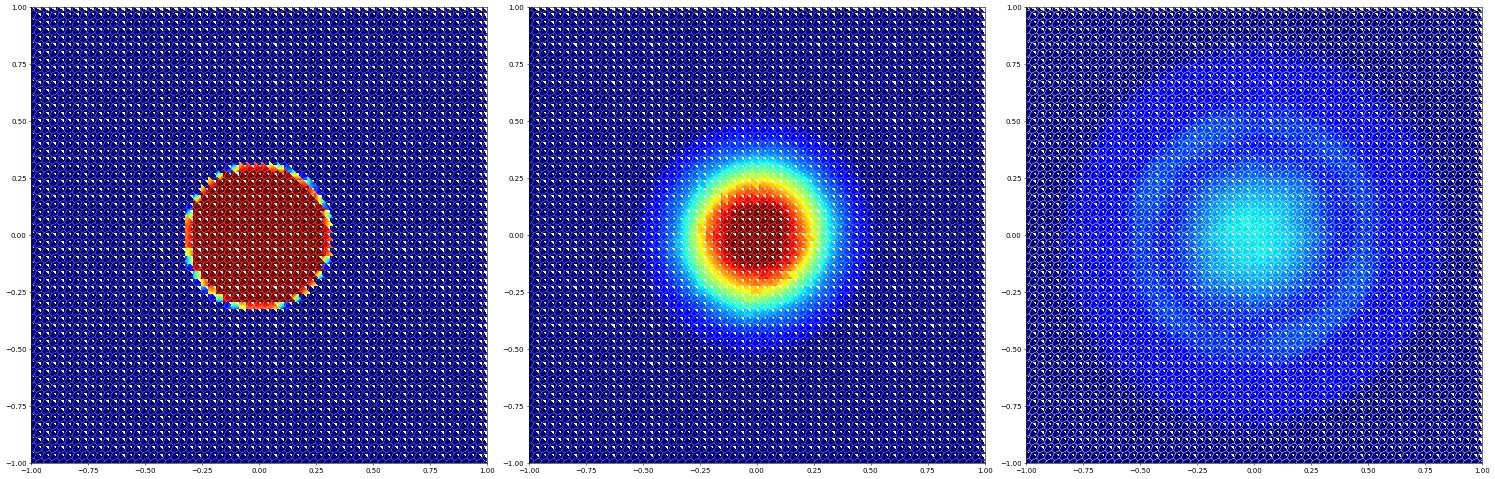

In [13]:
u_h   = space.interpolate( initial, name="solution")
res["polygons (minmod)"] = evolve(space,u_h)

Solutions along the diagonal

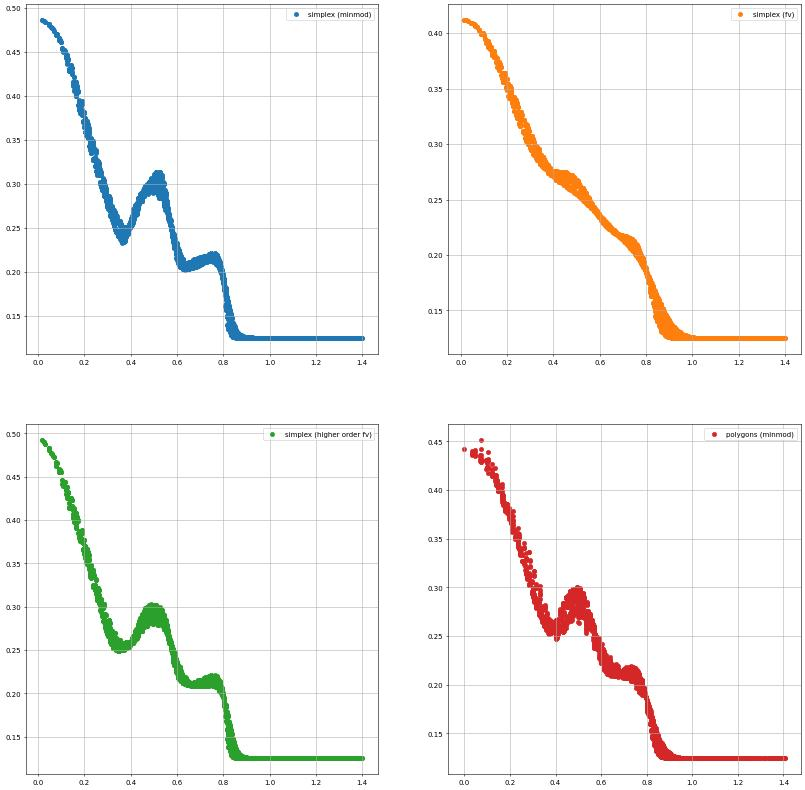

In [14]:
color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
figure = pyplot.figure(figsize=(20,20))
for i,(k,x) in enumerate(res.items()):
    ax = pyplot.subplot(221+i)
    ax.scatter(x[0],x[1], color=color[i], label=k)
    ax.legend()
    ax.grid(True)